In [1]:
import numpy as np

In [2]:
def stochastic_rounding(x):
    # takes the integer part of the number
    x_int = x.astype(np.int32)
    # takes the fractional part
    x_frac = np.abs(x - x_int)

    # generate a random number
    rng = np.random.random(x_int.shape)

    # if the frac is grater... for positive cases
    rounded_pos = np.where(x_frac > rng, x_int + 1, x_int)

    # if the grac is greate... for negative cases
    rounded_neg = np.where(x_frac > rng, x_int - 1, x_int)

    # select the rounded according to the signal
    rounded = np.where(x < 0, rounded_neg, rounded_pos)
    
    return rounded

x = np.random.normal(0, 5, (5)) 
print("float ", x)
rx = 0
it = 100
for _ in range(it):
    rx += stochastic_rounding(x)

rx = rx.astype(np.float32) / it
print("stchr0", stochastic_rounding(x))
print("stchr1", rx)
print("round ", np.around(x).astype(np.int32))

float  [ 6.53394197  7.18238187 -5.66617495 -1.06247069  1.32029059]
stchr0 [ 7  7 -6 -1  1]
stchr1 [ 6.45  7.23 -5.72 -1.05  1.32]
round  [ 7  7 -6 -1  1]


In [3]:

def quantize(x, round_stoch = True):
    """ exponentiation and quantization function """

    # just to avoid numerical problems
    eps = 1e-8

    # extract the signal
    s = np.sign(x)

    # takes the abs
    abs_x = np.abs(x)

    cliped_abs_x = np.where(abs_x < eps, eps, abs_x) # clip the min value of abs. (this is just for avoid numercal problems)
    cliped_abs_x = np.where(cliped_abs_x > 1, 1, cliped_abs_x) # clip the max value of DN 

    # gets the exponent with base 2
    exp = np.log2(cliped_abs_x)

    # round to nearest and cast to int (use stochastic rounding)
    if round_stoch:
        round_exp = stochastic_rounding(exp)
    else:
        round_exp = (np.round(exp)).astype(np.int32)


    # stochastic zero
    
    # detect underflow
    underflow = np.where(round_exp < -7, 1, 0)

    # clip expoent in -7
    clip_exp = np.where(underflow, -7, round_exp)
    
    # randomize the signal
    s = np.where(np.logical_and(np.random.random(round_exp.shape) < 0.5, underflow), -s, s) 
    
    # convert to float32 again
    qx = s * np.power(2., clip_exp)
    return qx


for _ in range(10):
    x = np.random.normal(0, 0.2, (5)) 
    print("float ", x)
    print("quant0", quantize(x))
    print("quant1", quantize(x))
    print("quant2", quantize(x))    
    print("-------")

float  [-0.01440933  0.02540248 -0.05470389  0.28517869  0.21798591]
quant0 [-0.015625  0.03125  -0.0625    0.5       0.25    ]
quant1 [-0.015625  0.015625 -0.0625    0.25      0.25    ]
quant2 [-0.015625  0.03125  -0.03125   0.25      0.25    ]
-------
float  [-0.56334702 -0.24973073  0.35693944 -0.05589206  0.02588816]
quant0 [-1.      -0.25     0.5     -0.0625   0.03125]
quant1 [-1.      -0.25     0.25    -0.0625   0.03125]
quant2 [-1.      -0.25     0.5     -0.03125  0.03125]
-------
float  [-0.02326436 -0.1596331  -0.42372306  0.02349555 -0.02922413]
quant0 [-0.015625 -0.25     -0.5       0.015625 -0.03125 ]
quant1 [-0.03125 -0.25    -0.25     0.03125 -0.03125]
quant2 [-0.015625 -0.125    -0.25      0.015625 -0.03125 ]
-------
float  [ 0.09272431  0.08045587  0.14000535 -0.25516182  0.11192616]
quant0 [ 0.0625  0.125   0.125  -0.25    0.125 ]
quant1 [ 0.125   0.0625  0.25   -0.25    0.125 ]
quant2 [ 0.125  0.125  0.125 -0.25   0.125]
-------
float  [ 0.03438952 -0.19086508 -0.1258

In [4]:
a = np.array([0,1,0,1])
b = np.array([1,1,0,0])

print(np.logical_and(a, b))

print(np.sign(-2))

[False  True False False]
-1


In [20]:
# visualizing
import matplotlib.pyplot as plt


# range of values from -2,2 
float_values = np.arange(-1, 1, 0.001)


sx4_values = quantize(float_values, True)
sx4_round_values = quantize(float_values, False)


sx4_over_time = quantize(float_values, True)
for _ in range(100):
    sx4_over_time += quantize(float_values, True)
sx4_over_time /= 100


print(float_values.shape)
print(sx4_values.shape)

(2000,)
(2000,)


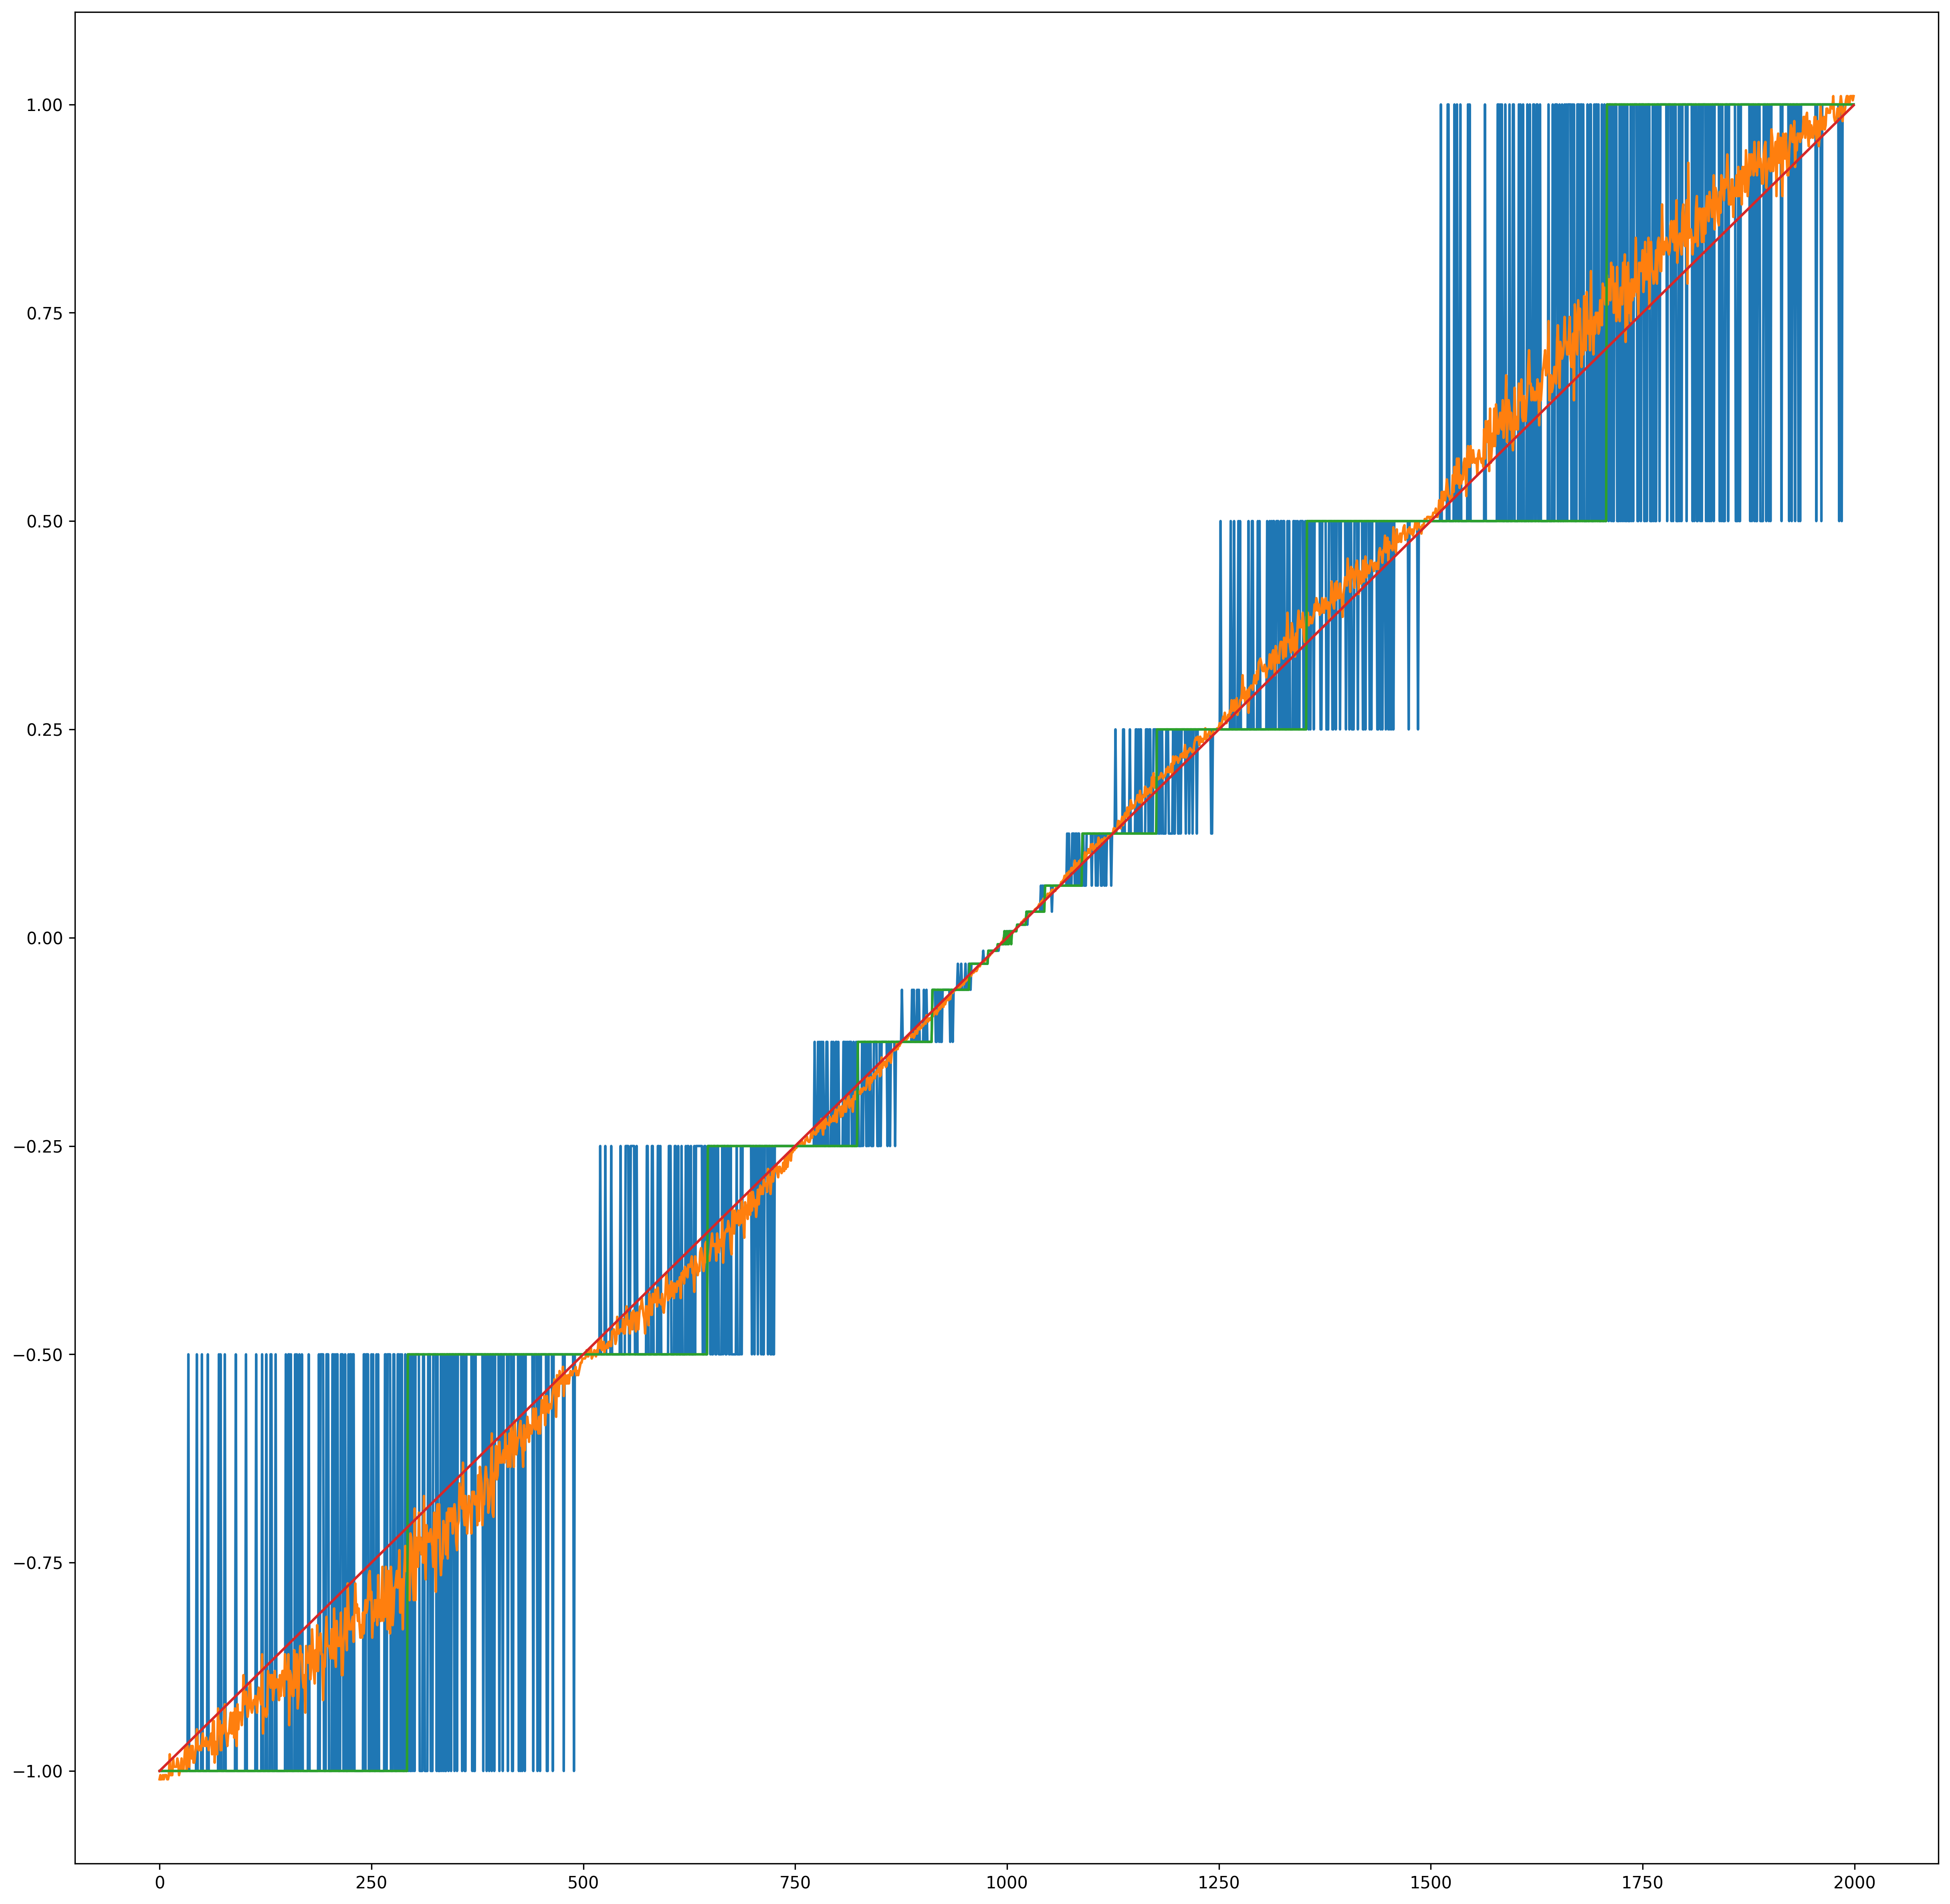

In [22]:
plt.figure(figsize=(20,20), dpi=300)
plt.plot(sx4_values)
plt.plot(sx4_over_time)
plt.plot(sx4_round_values)
plt.plot(float_values)
plt.show()

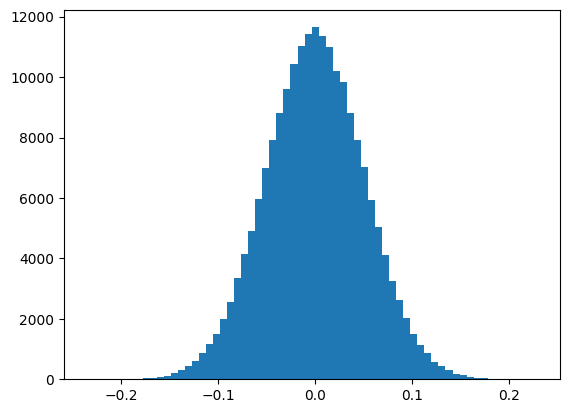

In [17]:
import numpy as np
import matplotlib.pyplot as plt


a = np.random.randn(784, 256) * np.sqrt(2/784)

plt.hist(np.ravel(a), bins=64)
plt.show()